In [ ]:
## Clean up comments
## Start APRA data next

#############################################################

# Project: External Finance Data 

# Step: Combine RBA Credit and Debit Data

# Purpose: Provide insights into Australian Debit and Credit Card Data 
# usage

# Author: Michael Letheby

# Version: 
#    1.0 - 2/12/2021 
#        - Created additional section for RBA Debit Card Data

#############################################################

In [1]:
#############################################################

# Section: Libraries

#############################################################

import pandas as pd # Data Analysis Library
import matplotlib.pyplot as plt # Data Visualisation Library
import matplotlib.ticker as ticker
%matplotlib inline

import seaborn as sns # Data Visualisation Library
import requests # For downloading 
import datetime
import re # Regex
import numbers 

import pickle # for saving/loading files

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
#############################################################

# Section: Functions

#############################################################

# pickle_save: save the files after importing and reading them
def pickle_save(name, to_save):
    with open('./Data/' + name + '.pickle', 'wb') as handle:
        pickle.dump(to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)
# picle_load: load previously saved files
def pickle_load(name):
    with open('./Data/' + name + '.pickle', 'rb') as handle:
        load_data = pickle.load(handle)
    return load_data

# match: search each string element within a list ('list_search') in a string ('in_string') and  
# return the match. Used to define the type of variable within the ABS Lending Indicator datasets.
def match(list_search, in_string):
    # need to add restrictions on input types to list + string
    result = [f for f in list_search if re.search(f, desclist)] 
    return(result)

# human_format: format numbers to be more readable 
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])

In [3]:
final_table_dict = pickle_load('imported_data_final')

In [46]:
rba_debit_df = final_table_dict['RBA-Debit']['Final_Data']
rba_credit_df = final_table_dict['RBA-Credit']['Final_Data']

In [47]:
rba_debit_df = rba_debit_df[rba_debit_df['Date'] >= '2018-01-01'] # In order to calculate MoM + YoY

# Create new features required for analysis

rba_debit_df['Date_Axis'] = rba_debit_df['Date'].dt.strftime("%b-%y")
rba_debit_df['Year'] = rba_debit_df['Date'].dt.year
rba_debit_df['Month'] = rba_debit_df['Date'].dt.strftime("%b")

rba_debit_df['Product'] = 'Debit'

# Make sure the table is ordered first
rba_debit_df = rba_debit_df.sort_values(by=['Date'])
rba_debit_df = rba_debit_df.reset_index(drop=True)

# compare this against Credit Card
rba_debit_df['Average Transaction Value'] = rba_debit_df['transaction value']/(rba_debit_df['transactions']*1000000) 
rba_debit_df['Transaction Value MoM'] = rba_debit_df['transaction value'] - rba_debit_df['transaction value'].shift(periods=1)
rba_debit_df['Transaction Value MoM Percent'] = rba_debit_df['transaction value']/rba_debit_df['transaction value'].shift(periods=1)-1
rba_debit_df['Transaction Value YoY'] = rba_debit_df['transaction value'] - rba_debit_df['transaction value'].shift(periods=12)
rba_debit_df['Transaction Value YoY Percent'] = rba_debit_df['transaction value']/rba_debit_df['transaction value'].shift(periods=12)-1
rba_debit_df = rba_debit_df[rba_debit_df['Date'] >= '2019-01-01'].reset_index(drop=True) 

In [48]:
rba_credit_df['Date_Axis'] = rba_credit_df['Date'].dt.strftime("%b-%y")
rba_credit_df['Product'] = 'Credit'
rba_credit_df = rba_credit_df[rba_credit_df['Date'] >= '2019-01-01'].reset_index(drop=True) 

In [49]:
# Summary stats 

# Latest month results for commentary

max_date = max(rba_debit_df['Date'])
latest_date = rba_debit_df[rba_debit_df['Date'] == max_date]
latest_accounts_fmt = human_format(latest_date['accounts'].values[0])
latest_transaction_value_fmt = '$' + human_format(latest_date['transaction value'].values[0])
latest_transaction_MoM_fmt = '$' + human_format(latest_date['Transaction Value MoM'].values[0])
latest_transaction_MoMPer_fmt = '{:,.1f}'.format(latest_date['Transaction Value MoM Percent'].values[0]*100) + '%'
latest_transaction_YoY_fmt = '$' + human_format(latest_date['Transaction Value YoY'].values[0])
latest_transaction_YoYPer_fmt = '{:,.1f}'.format(latest_date['Transaction Value YoY Percent'].values[0]*100) + '%'

In [32]:
# Commentary
print("In ", max_date.strftime("%b-%y"), ":",  sep='')
print("   -There were", latest_accounts_fmt, "open Debit Accounts.")  
print("   -Total Transactions were", latest_transaction_value_fmt)
print("      -MoM Transactions changed by ", latest_transaction_MoM_fmt, " (", latest_transaction_MoMPer_fmt, ")", sep='')
print("      -YoY Transactions changed by ", latest_transaction_YoY_fmt, " (", latest_transaction_YoYPer_fmt, ")", sep='')

In Sep-21:
   -There were 36M open Debit Accounts.
   -Total Transactions were $35.8B
      -MoM Transactions changed by $422M (1.2%)
      -YoY Transactions changed by $1.93B (5.7%)


In [50]:
rba_combined = [rba_debit_df[['Date_Axis', 'transaction value', 'Product']], 
                rba_credit_df[['Date_Axis', 'transaction value', 'Product']]]

rba_combined_df = pd.concat(rba_combined)

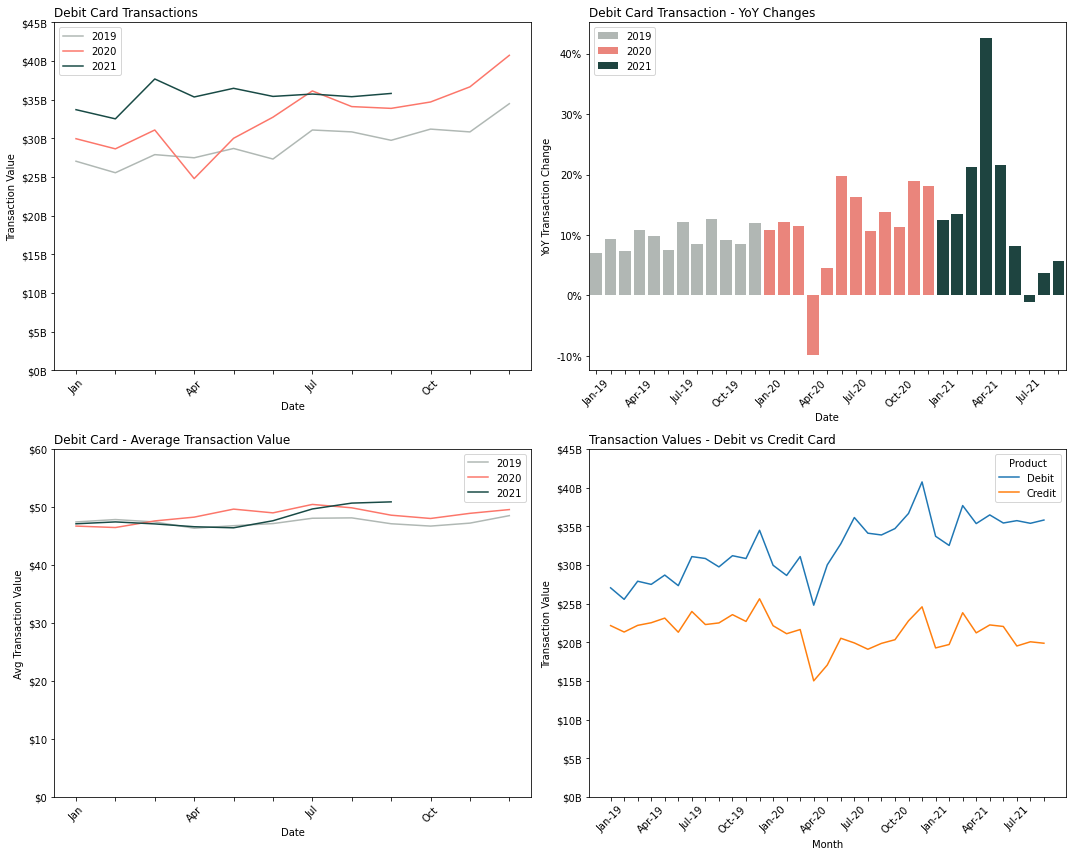

In [64]:
f, axes = plt.subplots(2,2, figsize=(15,12))

max_y_trans = int(round(max(rba_debit_df['transaction value']),-10))+5000000000
max_y_trans_avg = int(round(max(rba_debit_df['Average Transaction Value']),-1))+10

palette_custom = ['#B0B8B4FF', '#FC766AFF', '#184A45FF']

# Transaction Volumes 
trans_val_graph = sns.lineplot(x='Month', y='transaction value', data=rba_debit_df, hue = 'Year', palette = palette_custom,
                               ax=axes[0,0])
trans_val_graph.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '${:,.0f}'.format(y/1E9) + 'B'))

# Credit Card Balance YoY Change
trans_YoY_graph = sns.barplot(x='Date_Axis', y='Transaction Value YoY Percent', data=rba_debit_df, hue='Year', palette = palette_custom, 
                                dodge=False, ax=axes[0,1])
trans_YoY_graph.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y*100) + '%'))

# Average Transaction Value
trans_avg_graph = sns.lineplot(x='Month', y='Average Transaction Value', data=rba_debit_df, hue = 'Year', palette = palette_custom,
                               ax=axes[1,0])
trans_avg_graph.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '${:,.0f}'.format(y)))

# Debit vs Credit Card Values
trans_compare_graph = sns.lineplot(x='Date_Axis', y='transaction value', data=rba_combined_df, hue = 'Product', 
                               ax=axes[1,1])
trans_compare_graph.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '${:,.0f}'.format(y/1E9) + 'B'))

graphs = []

# Use value NONE where invalid
graphs.append({
    'graph': trans_val_graph,
    'title': 'Debit Card Transactions',
    'label-x': 'Date',
    'label-y': 'Transaction Value',
    'legend': 'upper left',
    'limit-x-lower': 'NONE',
    'limit-x-upper': 'NONE',  
    'limit-y-lower': 0,
    'limit-y-upper': max_y_trans,  
    'rotate-x-ticks': 45,
    'date-axis-spread': 'Y',
    'secondary-graph': 'NONE',
    'secondary-label-y': 'NONE',
    'secondary-legend': 'NONE',
    'secondary-limit-y-lower': 'NONE',
    'secondary-limit-y-upper': 'NONE'
})

graphs.append({
    'graph': trans_YoY_graph,
    'title': 'Debit Card Transaction - YoY Changes',
    'label-x': 'Date',
    'label-y': 'YoY Transaction Change',
    'legend': 'upper left',
    'limit-x-lower': 'NONE',
    'limit-x-upper': 'NONE',  
    'limit-y-lower': 'NONE',
    'limit-y-upper': 'NONE',  
    'rotate-x-ticks': 45,
    'date-axis-spread': 'Y',
    'secondary-graph': 'NONE',
    'secondary-label-y': 'NONE',
    'secondary-legend': 'NONE',
    'secondary-limit-y-lower': 'NONE',
    'secondary-limit-y-upper': 'NONE'
})

graphs.append({
    'graph': trans_avg_graph,
    'title': 'Debit Card - Average Transaction Value',
    'label-x': 'Date',
    'label-y': 'Avg Transaction Value',
    'legend': 'upper right',
    'limit-x-lower': 'NONE',
    'limit-x-upper': 'NONE',  
    'limit-y-lower': 0,
    'limit-y-upper': max_y_trans_avg,  
    'rotate-x-ticks': 45,
    'date-axis-spread': 'Y',
    'secondary-graph': 'NONE',
    'secondary-label-y': 'NONE',
    'secondary-legend': 'NONE',
    'secondary-limit-y-lower': 'NONE',
    'secondary-limit-y-upper': 'NONE'
})

graphs.append({
    'graph': trans_compare_graph,
    'title': 'Transaction Values - Debit vs Credit Card',
    'label-x': 'Month',
    'label-y': 'Transaction Value',
    'legend': 'NONE',
    'limit-x-lower': 'NONE',
    'limit-x-upper': 'NONE',  
    'limit-y-lower': 0,
    'limit-y-upper': max_y_trans,  
    'rotate-x-ticks': 45,
    'date-axis-spread': 'Y',
    'secondary-graph': 'NONE',
    'secondary-label-y': 'NONE',
    'secondary-legend': 'NONE',
    'secondary-limit-y-lower': 'NONE',
    'secondary-limit-y-upper': 'NONE'
})

# need to add a counter here
for graph in graphs: #Loop to set all graph parameters
    graph['graph'].set_title(graph['title'], loc='left') 
    graph['graph'].set(xlabel=graph['label-x'], ylabel=graph['label-y'])
    
    if graph['legend'] != 'NONE': # Legend
        graph['graph'].legend(loc=graph['legend']) 
    if graph['limit-x-lower'] != 'NONE': # X Limits
        graph['graph'].set_xlim(graph['limit-x-lower'], graph['limit-x-upper']) 
    if graph['limit-y-lower'] != 'NONE': # Y Limits
        graph['graph'].set_ylim(graph['limit-y-lower'], graph['limit-y-upper'])       
    if graph['rotate-x-ticks'] != 'NONE': # X Tick Rotation
        graph['graph'].xaxis.set_tick_params(labelrotation=graph['rotate-x-ticks'])
    if graph['date-axis-spread'] == 'Y':
        for ind, label in enumerate(graph['graph'].get_xticklabels()):
            if ind % 3 == 0:  # every 3rd label is kept
                label.set_visible(True)
            else:
                label.set_visible(False)
    
    if graph['secondary-graph'] != 'NONE':
        graph['secondary-graph'].set(ylabel=graph['secondary-label-y'])
        
        if graph['secondary-legend'] != 'NONE':
            graph['secondary-graph'].legend(loc=graph['secondary-legend']) 
        if graph['secondary-limit-y-lower'] != 'NONE':
            graph['secondary-graph'].set_ylim(graph['secondary-limit-y-lower'], graph['secondary-limit-y-upper'])     

plt.tight_layout()
plt.show()